# Import modules

In [3]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader

from bnaf.toy2d import main as bnaf
from bnaf.toy2d import compute_log_p_x
import torch

reproducibility.clear_cache()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Plugins(categories=["generic"]).list()


/home/bv292/miniconda/envs/test_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['sdv_tvae',
 'nflow',
 'tvae',
 'copulagan',
 'ctgan',
 'gaussian_copula',
 'rtvae',
 'adsgan',
 'dpgan',
 'bayesian_network',
 'sdv_ctgan',
 'pategan',
 'privbayes']

# Load data and settings

In [4]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons
from bnaf.data.generate2d import sample2d

dataset = 'moons'
p_train = 0.5
nsyn = 5000

if dataset == 'diabetes':
    X, y = load_diabetes(return_X_y=True, as_frame=True)
elif dataset == 'iris':
    X, y = load_iris(return_X_y=True, as_frame=True)
elif dataset == 'boston':
    X, y = load_boston(return_X_y=True, as_frame=True)
elif dataset == 'breast_cancer':
    X, y = load_breast_cancer(return_X_y=True, as_frame=True)
elif dataset == 'wine':
    X, y = load_wine(return_X_y=True, as_frame=True)
elif dataset == 'digits':
    X, y = load_digits(return_X_y=True, as_frame=True)
elif dataset == 'moons':
    X, y = make_moons(n_samples=10000, noise=0.2, random_state=0)
    X = pd.DataFrame(X)
    p_train = 0.2
elif dataset in ["8gaussians", "2spirals", "checkerboard", "t1", "t2", "t3", "t4"]:
    X = sample2d(dataset, 20000)
    X = pd.DataFrame(X)
    y = -np.ones(X.shape[0])
    p_train = 0.5
    nsyn = 20000
elif dataset == 'gaussian':
    n_real = 40000
    X = np.random.randn(n_real, 2)
    X = pd.DataFrame(X)
    noise = 2
    y = X[0] > noise*(np.random.uniform(size=n_real)-1/2)
    p_train = 0.1
elif dataset == 'uniform':
    n_real = 10000
    X = np.random.uniform(size=(n_real, 2))
    X = pd.DataFrame(X)
    y = X[0] > np.random.uniform(size=n_real)
    p_train = 0.1
else:
    raise ValueError('Unknown dataset')

X["target"] = y
X_gt = GenericDataLoader(X, target_column="target", train_size=p_train)

if len(np.unique(y)) == 1:
    X_gt.targettype = None
elif len(np.unique(y)) <= 10:
    X_gt.targettype = 'classification'
else:
    X_gt.targettype = 'regression'

X_train, X_test = X_gt.train(), X_gt.test()


n_train = X_train.shape[0]
model_name = 'tvae'
results_folder = "uncertainty_results/"+dataset+"/"+model_name
workspace_folder = "workspace/"+dataset+"/"+model_name
n_models = 10
load = True
load_syn = True
save = True


# Generate data

In [5]:

for i in range(n_models):
    os.makedirs(results_folder, exist_ok=True)
    filename = f"{results_folder}/Xsyn_n{n_train}_seed{i}.pkl"
    # filename2 = f"{results_folder}/X_syn_{i}.pkl"
    # if os.path.exists(filename2):
    #     os.rename(filename2, filename)
    if os.path.exists(filename) and load_syn:
        continue
    print(f"Training model {i+1}/{n_models}")

    reproducibility.enable_reproducible_results(seed=i)
    syn_model = Plugins().get(model_name)
    syn_model.fit(X_train)
    X_syn = syn_model.generate(count=nsyn)
    X_syn.targettype = X_gt.targettype
    # save X_syn to disk as pickle
    pickle.dump(X_syn, open(filename, "wb"))
    # save model to disk as pickle
    # filename = f"{results_folder}/{model_name}_n{n_train}_seed{i}.pkl"
    # pickle.dump(syn_model, open(filename, "wb"))

    


# Load data

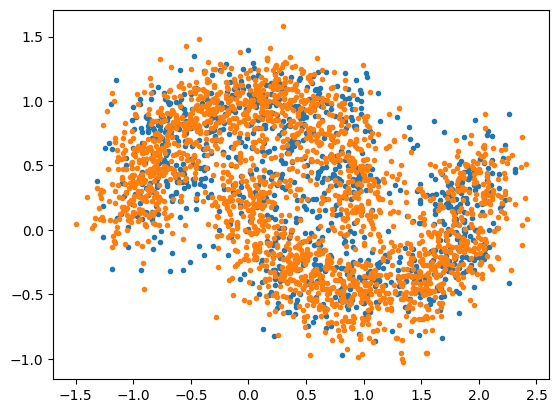

In [6]:
X_syns = []
for i in range(n_models):
    # load X_syn from disk as pickle
    X_syn = pickle.load(open(f"{results_folder}/Xsyn_n{n_train}_seed{i}.pkl", "rb"))
    X_syn.targettype = X_gt.targettype
    X_syns.append(X_syn)

# plot what we generated
X_syn_all = np.concatenate([X_syns[i].unpack(as_numpy=True)[0]
                           for i in range(len(X_syns))])
a = X_syn_all[np.random.choice(X_syn_all.shape[0], 1000, replace=False)]
plt.scatter(a[:, 0], a[:, 1], marker='.')
b = X_gt.train().unpack(as_numpy=True)[0]
plt.scatter(b[:, 0], b[:, 1], marker='.')


# Helper functions

In [7]:

import xgboost
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, r2_score, mean_squared_error, mean_absolute_error, log_loss, brier_score_loss
from sklearn.model_selection import KFold, train_test_split

def cat_dl(X_syns, n_limit=None):
    """
    Concatenate a list of GenericDataLoader objects into one GenericDataLoader object
    """
    if n_limit is not None:
        X_syn_cat = pd.concat([X_syns[i][:n_limit]
                              for i in range(len(X_syns))], axis=0)
    else:
        X_syn_cat = pd.concat([X_syns[i].dataframe()
                              for i in range(len(X_syns))], axis=0)
    X_syn_cat = GenericDataLoader(X_syn_cat, target_column="target")
    X_syn_cat.targettype = X_syns[0].targettype
    return X_syn_cat
    

def parallel_for(func, args_list, max_workers=4):
    from concurrent.futures import ThreadPoolExecutor
    
    # Create a ThreadPoolExecutor with the desired number of threads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Use the executor to map the function over the list of arguments
        results = executor.map(func, args_list)
    
    return results

def init_model(model_type, targettype):
    """
    Initialize a model of the given type.
    """
    if model_type == 'lr':
        if targettype == 'classification':
            model = sklearn.linear_model.LogisticRegression()
        else:
            model = sklearn.linear_model.LinearRegression()
    elif model_type == 'mlp':
        if targettype == 'classification':
            model = sklearn.neural_network.MLPClassifier()
        else:
            model = sklearn.neural_network.MLPRegressor()
    elif model_type == 'rf':
        if targettype == 'classification':
            model = sklearn.ensemble.RandomForestClassifier()
        else:
            model = sklearn.ensemble.RandomForestRegressor()
    elif model_type == 'knn':
        if targettype == 'classification':
            model = sklearn.neighbors.KNeighborsClassifier()
        else:
            model = sklearn.neighbors.KNeighborsRegressor()
    elif model_type == 'svm':
        if targettype == 'classification':
            model = sklearn.svm.SVC()
        else:
            model = sklearn.svm.SVR()
    elif model_type == 'xgboost':
        if targettype == 'classification':
            model = xgboost.XGBClassifier()
        else:
            model = xgboost.XGBRegressor()
    else:
        raise ValueError('Unknown model type')
    return model


def prediction_task(X_gt, X_syn, model=None, model_type='mlp', verbose=False):
    if type(model) == str or model is None:
        model = init_model(model_type, X_gt.targettype)
        X, y = X_syn.unpack(as_numpy=True)
        model.fit(X, y.reshape(-1, 1))
    pred = model.predict(X_gt.unpack(as_numpy=True)[0])
    return pred, model


def compute_metrics(y_test, yhat_test, targettype = 'classification'):
    if targettype == 'classification':
        metrics = ['roc_auc', 'accuracy', 'f1', 'precision', 'recall', 'nll', 'brier',]
        scores = [roc_auc_score(y_test, yhat_test), accuracy_score(y_test, yhat_test),
                  f1_score(y_test, yhat_test), precision_score(y_test, yhat_test), recall_score(y_test, yhat_test),
                  log_loss(y_test, yhat_test), brier_score_loss(y_test, yhat_test)]
    elif targettype == 'regression':
        metrics = ['r2', 'mse', 'mae']
        scores = [r2_score(y_test, yhat_test), mean_squared_error(
            y_test, yhat_test), mean_absolute_error(y_test, yhat_test)]
    else:
        raise ValueError('unknown target type')
    
    scores = np.array(scores).reshape(1, -1)
    scores = pd.DataFrame(scores, columns=metrics)
    return scores
        


def tt_predict_performance(X_test, X_train, model=None, model_type='mlp', verbose=False):
    """compute train_test performance for different metrics"""
    # import metrics

    x_train, y_train = X_syn.unpack(as_numpy=True)
    x_test, y_test = X_test.unpack(as_numpy=True)

    
    if model is None:
        model = init_model(model_type, X_gt.targettype)
        model.fit(x_train, y_train)

    yhat_test = model.predict(x_test)
    scores = compute_metrics(y_test, yhat_test, X_gt.targettype)
    return scores, model


def aggregate_predictive(X_gt, X_syns, task=tt_predict_performance, models=None, task_type='', load=True, save=True,
                         approach='us', relative = False, run_for_all = True, verbose=False):
    """
    aggregate predictions from different synthetic datasets
    """

    results = []
    stds = []
    trained_models = []
    filename = ''
    fileroot = f'{workspace_folder}/{task.__name__}_{task_type}'
    if not os.path.exists(fileroot) and save:
        os.makedirs(fileroot)

    if run_for_all:
        range_limit = len(X_syns)
    else:
        range_limit = 1
    for i in range(range_limit):
        if models is None:
            if verbose:
                print(f'Saving model as {fileroot}_{filename}{i}.pkl')

            if os.path.exists(f'{fileroot}_{filename}{i}.pkl') and load:
                model = pickle.load(open(f"{fileroot}_{filename}{i}.pkl", "rb"))
            else:
                model = None
                print(f'Train model {i+1}/{len(X_syns)}')
        else:
            model = models[i]
        reproducibility.enable_reproducible_results(seed=i+2022)
        X_train = X_syns[i].train()
        if approach == 'single':
            X_test = X_syns[i].test()
        elif approach == 'us':
            X_syns_not_i = [X_syns[j] for j in range(len(X_syns)) if j != i]
            X_syns_not_i[0].targettype = X_gt.targettype
            X_test = cat_dl(X_syns_not_i)
        elif approach == 'us_new':
            X_syns_not_i = [X_syns[j] for j in range(len(X_syns)) if j != i]
        elif approach == 'oracle':
            X_test = X_gt.test()
        else:
            raise ValueError('Unknown approach')
        
        if not approach == 'us_new':
            X_test.targettype = X_gt.targettype
            X_train.targettype = X_gt.targettype
            
            res, model = task(X_test, X_train, model, task_type, verbose)

            if relative and approach != 'oracle':
                X_test = X_gt.test()
                X_test.targettype = X_gt.targettype
                res_oracle, model = task(X_test, X_train, model, task_type, verbose)
                
                if relative == 'l2':
                    res = (res - res_oracle)**2
                elif relative == 'l1':
                    res = (res - res_oracle).abs()
                else:
                    raise ValueError('Unknown relative metric')

        else:
            if relative:
                raise ValueError('Relative not implemented for us_new')
            res = []
            for j in range(len(X_syns_not_i)):
                X_test = X_syns_not_i[j].test()
                X_test.targettype = X_gt.targettype
                X_train.targettype = X_gt.targettype
                res.append(task(X_test, X_train, model, task_type, verbose)[0])
            res, std = meanstd(pd.concat(res,axis=0))
            res = res
            stds.append(std)
            

        
        results.append(res)
        trained_models.append(model)
        # save model to disk as pickle
        if models is None and save:
            pickle.dump(model, open(f"{fileroot}_{filename}{i}.pkl", "wb"))

    results = pd.concat(results, axis=0)
    if approach != 'us_new':
        return *meanstd(results), trained_models
    else:
        stds = pd.concat(stds, axis=0)
        stds = stds.mean(axis=0).to_frame().T
        means, stds2 = meanstd(results)
        return means, (stds**2+stds2**2)**0.5, trained_models




def cv_predict_performance(X_gt, X_syn, model=None, model_type='mlp', n_splits=5, verbose=False):
    """compute cross-validated performance for different metrics"""

    # initialize KFold with fixed random state for reproducibility
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    x, y = X_syn.unpack(as_numpy=True)

    if X_gt.targettype == 'classification':
        metrics = ['roc_auc', 'accuracy', 'f1', 'precision', 'recall']
    elif X_gt.targettype == 'regression':
        metrics = ['r2', 'mse', 'mae']
    else:
        raise ValueError('unknown target type')

    models = model

    scores = []
    model_list = []

    for i, train_index, test_index in zip(range(n_splits), kf.split(X, y)):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if models is None:
            model = init_model(model_type, X_gt.targettype)
            model.fit(x_train, y_train)
        else:
            model = models[i]

        yhat_test = model.predict(x_test)

        if X_gt.targettype == 'classification':
            scores.append([roc_auc_score(y_test, yhat_test), accuracy_score(y_test, yhat_test), f1_score(
                y_test, yhat_test), precision_score(y_test, yhat_test), recall_score(y_test, yhat_test)])
        elif X_gt.targettype == 'regression':
            scores.append([r2_score(y_test, yhat_test), mean_squared_error(
                y_test, yhat_test), mean_absolute_error(y_test, yhat_test)])

        if models is None:
            model_list.append(model)

    if models is None:
        models = model_list

    scores = np.array(scores)
    # scores = np.concatenate((np.mean(scores, axis=0), np.std(scores, axis=0)),axis=1)
    # metrics = metrics + [f'{m}_std' for m in metrics]
    scores = pd.DataFrame(scores, columns=metrics)
    return scores, models


def meanstd(A):
    if type(A) == pd.DataFrame:
        return A.mean(axis=0).to_frame().T, A.std(axis=0).to_frame().T
    else:
        return np.mean(A, axis=0), np.std(A, axis=0)
    


def density_estimation(X_gt, X_syn, model=None, model_type='kde', verbose=False):
    """
    compute density estimation of X_syn, evaluate on X_gt
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    from scipy.stats import gaussian_kde
    if model_type == 'bnaf':

        if model is None:
            if verbose:
                print('Training BNAF')
            model = bnaf(X_syn.unpack(as_numpy=True)[0])
        X = torch.utils.data.TensorDataset(torch.tensor(
            X_gt.unpack(as_numpy=True)[0], device=device).to(torch.float32))
        X = torch.utils.data.DataLoader(X, batch_size=10000, shuffle=False)
        prob = torch.cat(
            [
                torch.exp(compute_log_p_x(model, x_mb)).detach()
                for x_mb, in X
            ],
            0,
        )
        return torch.exp(prob).detach().cpu().numpy(), model
    elif model_type == 'kde':
        if model is None:
            if verbose:
                print('Training KDE')
            model = gaussian_kde(X_syn.unpack(as_numpy=True)[0].T)
        return model.pdf(X_gt.unpack(as_numpy=True)[0].T), model


def aggregate(X_gt, X_syns, task, models=None, task_type='', load=True, save=True, filename='', verbose=False):
    """
    aggregate predictions from different synthetic datasets
    """

    results = []
    trained_models = []
    fileroot = f'{workspace_folder}/{task.__name__}_{task_type}'
    if not os.path.exists(fileroot) and save:
        os.makedirs(fileroot)

    for i in range(len(X_syns)):
        if models is None:
            if verbose:
                print(f'Saving model as {fileroot}_{filename}{i}.pkl')

            if os.path.exists(f'{fileroot}_{filename}{i}.pkl') and load:
                model = pickle.load(open(f"{fileroot}_{filename}{i}.pkl", "rb"))
            else:
                model = None
                print(f'Train model {i+1}/{len(X_syns)}')
        else:
            model = models[i]
        reproducibility.enable_reproducible_results(seed=i+2022)
        res, model = task(X_gt, X_syns[i], model, task_type, verbose)
        results.append(res)
        trained_models.append(model)
        # save model to disk as pickle
        if models is None and save:
            pickle.dump(model, open(f"{fileroot}_{filename}{i}.pkl", "wb"))

    return *meanstd(results), trained_models


def tsne(X):
    """
    Perform t-SNE dimensionality reduction to two dimensions
    """
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(X)
    return X_2d


def aggregate_imshow(X_gt, X_syns, task, models=None, task_type='', load=True, save=True, filename=''):
    """
    Aggregate and plot predictions from different synthetic datasets, on a 2D space. E.g., density estimation, predictions.
    """
    xmin, ymin = np.min(X_gt.train().unpack(as_numpy=True)[0], axis=0)*1.05
    xmax, ymax = np.max(X_gt.train().unpack(as_numpy=True)[0], axis=0)*1.05

    steps = 400
    X_grid = np.linspace(xmin, xmax, steps)
    Y_grid = np.linspace(ymin, ymax, steps)

    X_grid, Y_grid = np.meshgrid(X_grid, Y_grid)
    X_grid = pd.DataFrame(np.c_[X_grid.ravel(), Y_grid.ravel()])
    X_grid['target'] = -1
    X_grid = GenericDataLoader(X_grid, target_column="target", train_size=0.01)
    X_grid.targettype = X_gt.targettype

    y_pred_mean, y_pred_std, models = aggregate(
        X_grid, X_syns, task, models, task_type, load, save, f'n{len(X_gt.train().unpack()[0])}_{filename}')

    for y, stat in zip((y_pred_mean, y_pred_std), ('mean', 'std')):
        plt.figure(figsize=(8, 6), dpi=100)
        plt.imshow(y.reshape(steps, steps)[::-1],
                   cmap='viridis', extent=[xmin, xmax, ymin, ymax])
        plt.colorbar()
        if dataset == 'gaussian':
            plt.vlines(0, ymin, ymax, colors='r', linestyles='dashed')
        plt.savefig(f'{results_folder}/{task.__name__}_n{len(X_gt.train().unpack()[0])}_{filename}{stat}.png')
        plt.show()
        X_train, y_train = X_gt.train().unpack(as_numpy=True)
        if len(np.unique(y_train)) == 2:
            plt.imshow(y.reshape(steps, steps)[
                       ::-1], cmap='viridis', extent=[xmin, xmax, ymin, ymax])
            y_train = y_train.astype(bool)
            plt.scatter(X_train[y_train, 0], X_train[y_train, 1], c='k', marker='.')
            plt.scatter(X_train[~y_train, 0], X_train[~y_train, 1], c='w', marker='.')
            plt.colorbar()
            if dataset == 'gaussian':
                plt.vlines(0, ymin, ymax, colors='r', linestyles='dashed')
            plt.savefig(f'{results_folder}/{task.__name__}_n{len(X_gt.train().unpack()[0])}_{filename}{stat}_with_samples.png')
            plt.show()

    return y_pred_mean, y_pred_std, models


# Analyses

## Predictions across models

### Generative uncertainty

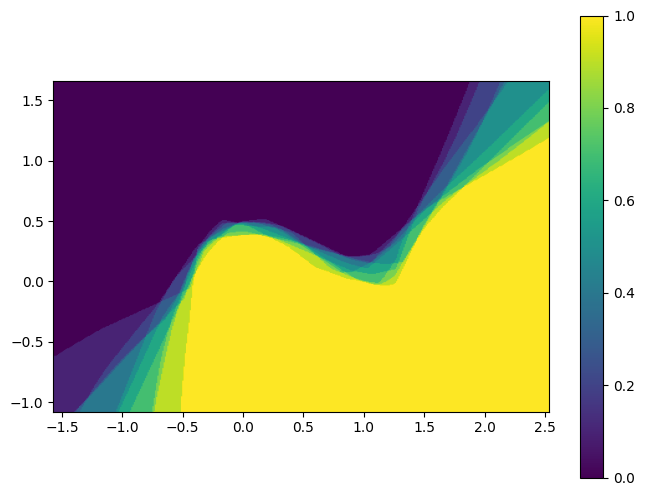

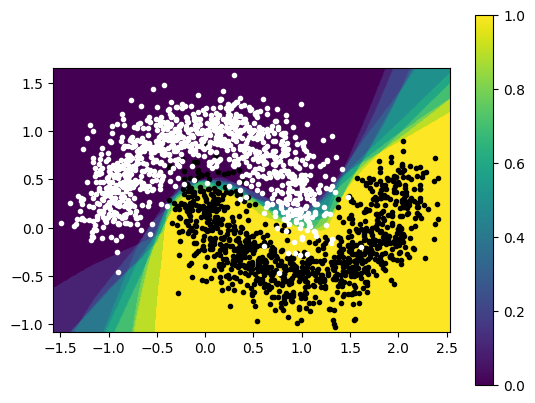

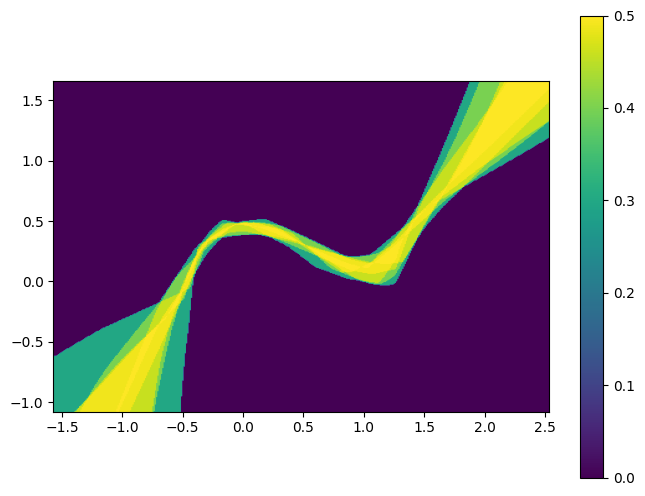

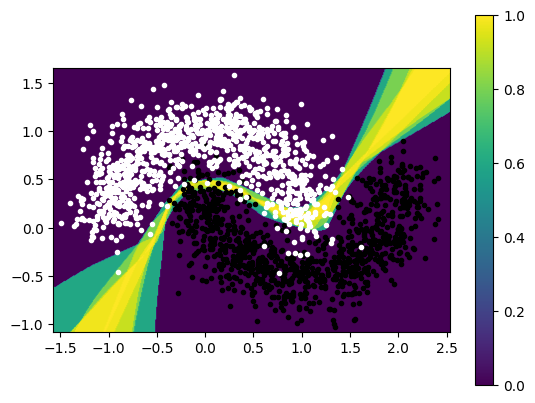

In [8]:
if X_gt.targettype is not None:
    y_pred_mean, y_pred_std, models = aggregate_imshow(
        X_gt, X_syns, prediction_task, models=None, task_type='mlp', load=load, save=save)

    # print('Predictions on test set:')
    # X, y = X_gt.test().unpack(as_numpy=True)
    # if X.shape[1]>2:
    #     Xplot = tsne(X)
    # else:
    #     Xplot = X
    # for y in [y_pred_mean, y_pred_std]:
    #     plt.scatter(Xplot[:,0], Xplot[:,1], c=y, cmap='viridis')
    #     plt.colorbar()
    #     plt.show()

    # print('Predictions on full space:')
    # aggregate_imshow(X_gt, X_syns, prediction_task, models)


### Single model

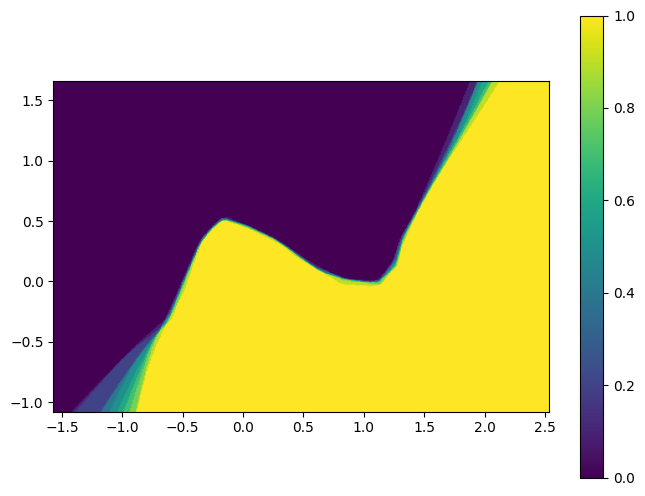

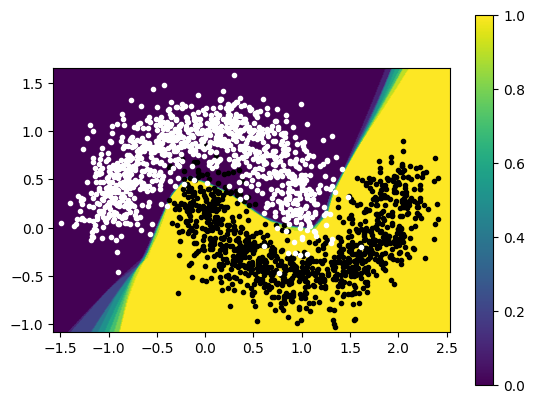

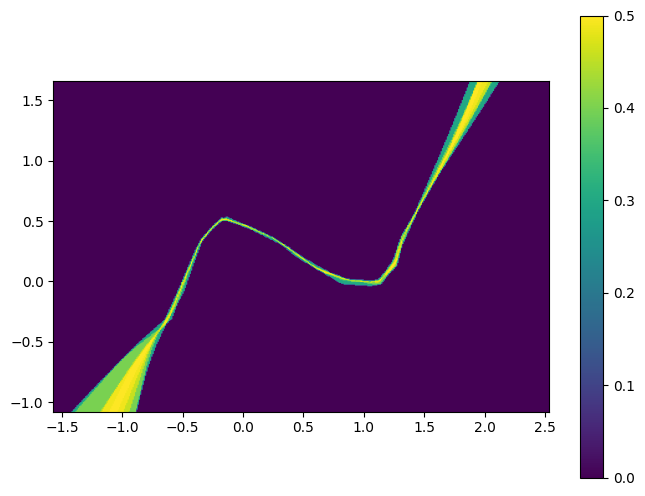

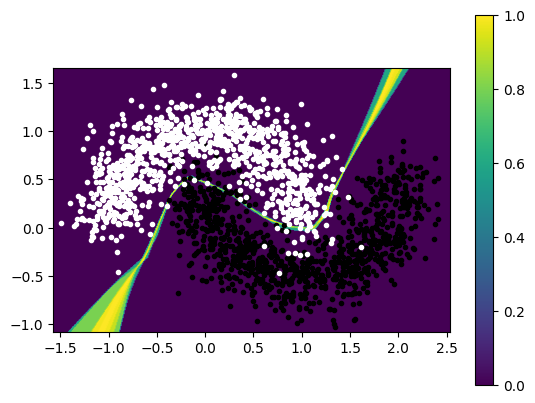

In [9]:
if X_gt.targettype is not None:
    X_syn_0 = [X_syns[0] for _ in range(len(X_syns))]
    y_pred_mean, y_pred_std, models = aggregate_imshow(
        X_gt, X_syn_0, prediction_task, models=None, task_type='mlp', load=load, save=save, filename='single')


### Data aggregated

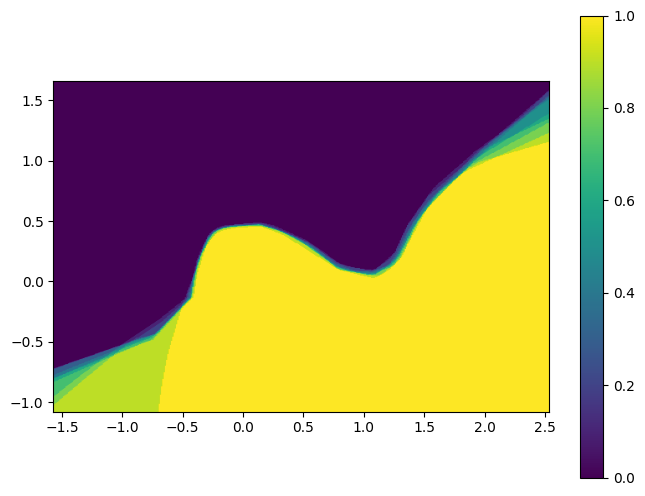

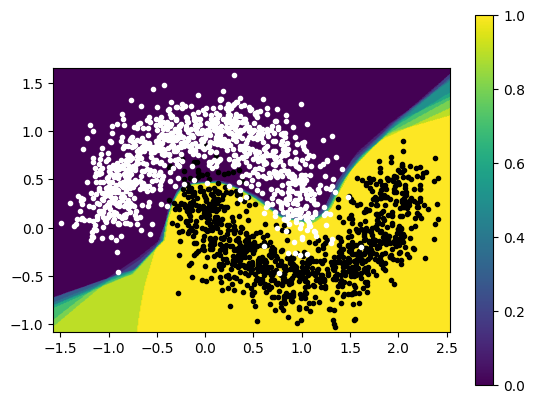

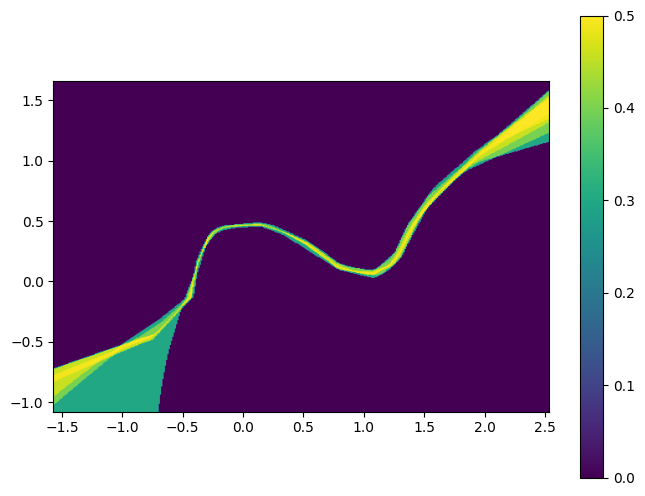

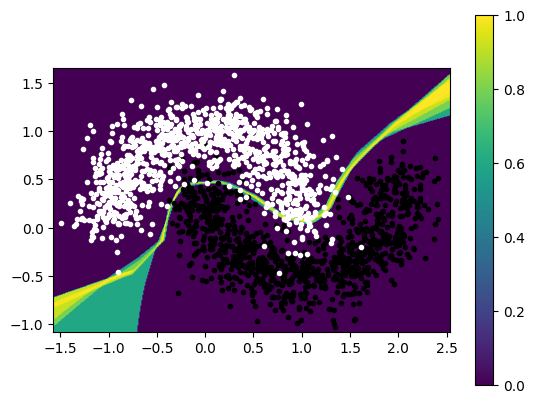

In [10]:
if X_gt.targettype is not None:
    X_syn_cat = pd.concat([X_syns[i].dataframe() for i in range(len(X_syns))], axis=0)
    X_syn_cat = GenericDataLoader(X_syn_cat, target_column="target")
    X_syn_cat = [X_syn_cat for _ in range(len(X_syns))]
    #X_syn_cat = [X_syn_cat.sample(len(X_syns[0])) for _ in range(len(X_syns))]

    y_pred_mean, y_pred_std, models = aggregate_imshow(
        X_gt, X_syn_cat, prediction_task, models=None, task_type='mlp', load=load, save=save, filename='aggregate')


## Density estimation
We ignore the target and regard density estimation as the downstream task. We use the flow-based BNAF from Cao as DE method.

In [11]:
if X_gt.targettype is None:
    X_test = X_gt.test()
    X_test.targettype = X_gt.targettype
    y_pred_mean, y_pred_std, models = aggregate_imshow(
        X_test, X_syns, density_estimation, models=None, task_type='kde', load=load, save=save)


## Influence of synthetic data size

Let's study the effect of synthetic data size.

### Generative uncertainty
Let us first look at the generative estimates

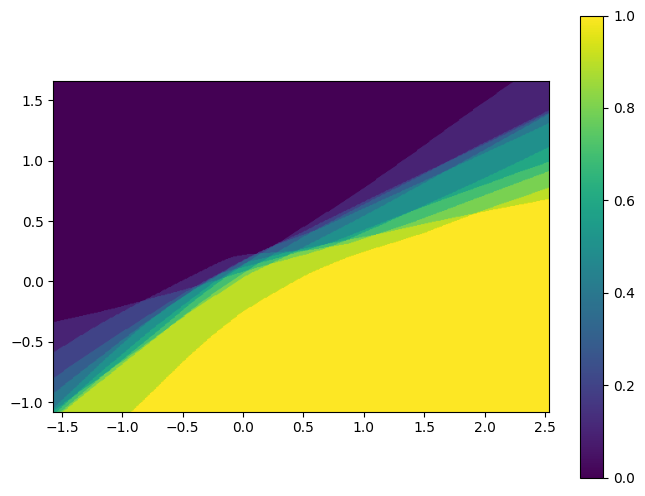

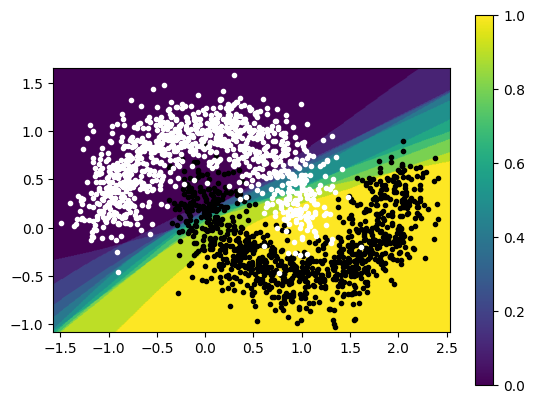

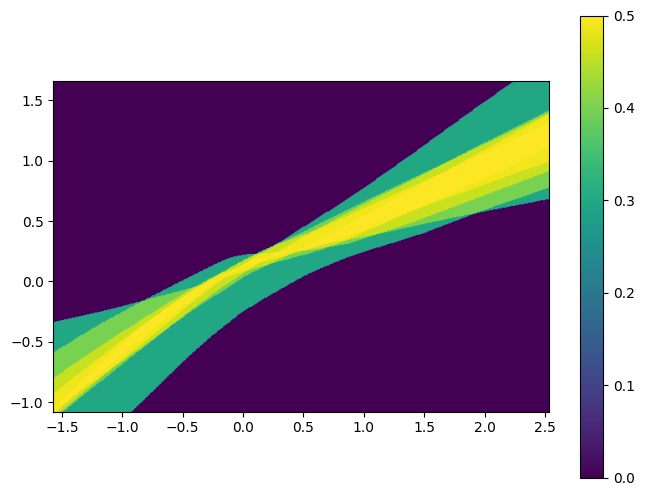

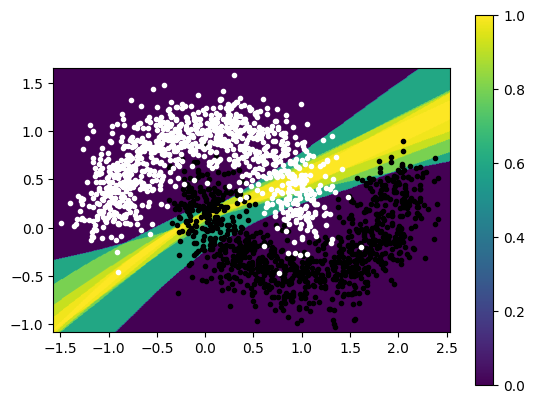

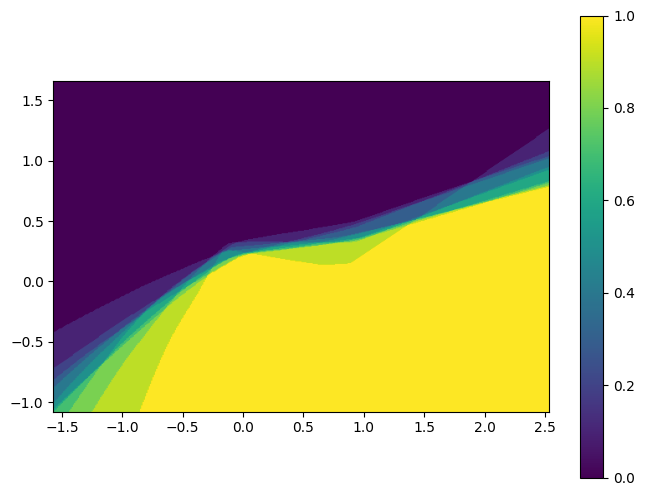

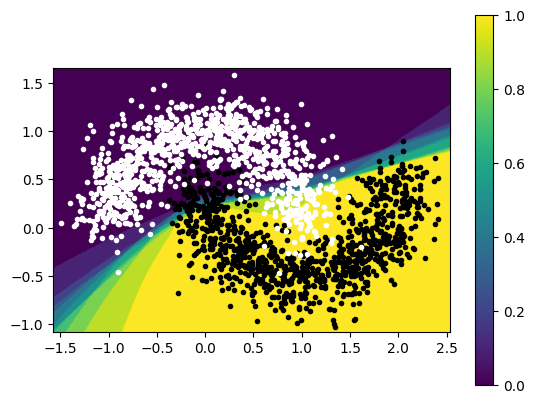

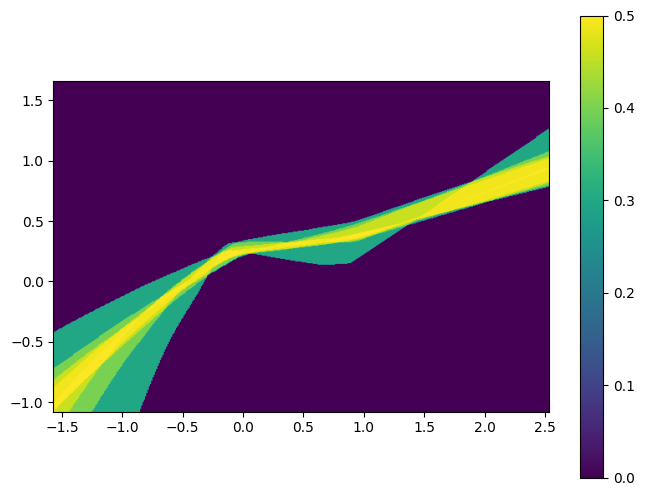

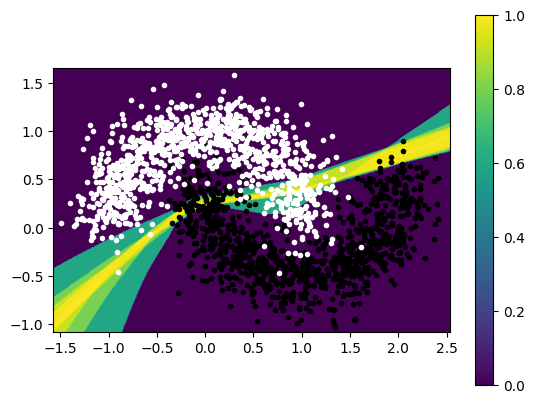

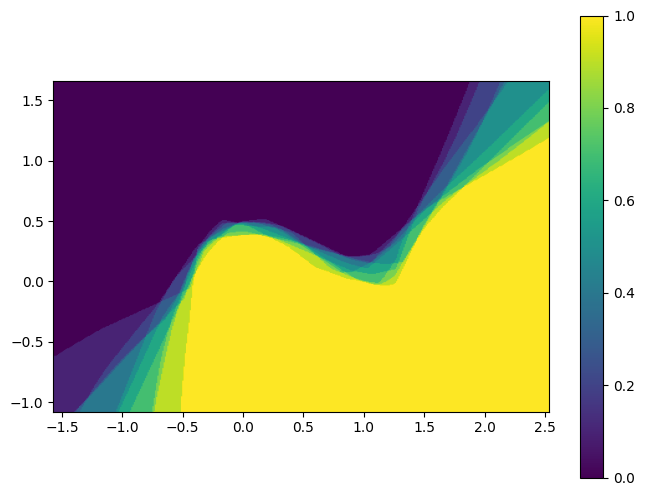

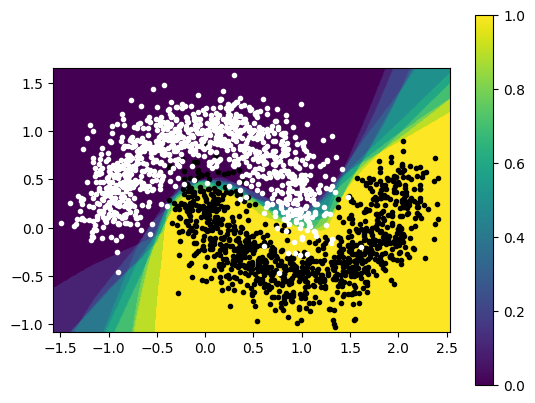

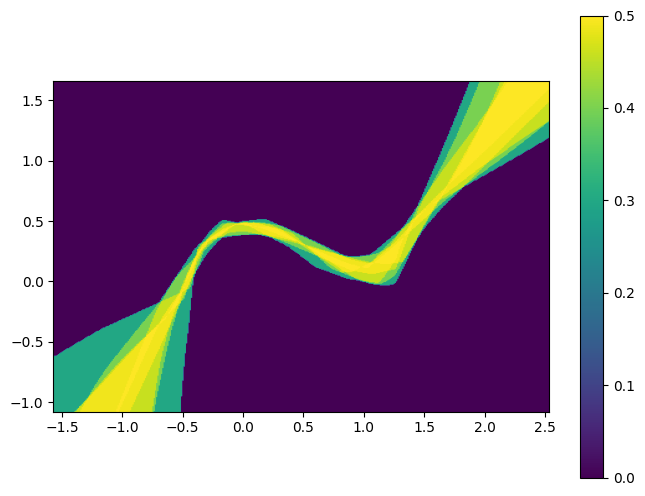

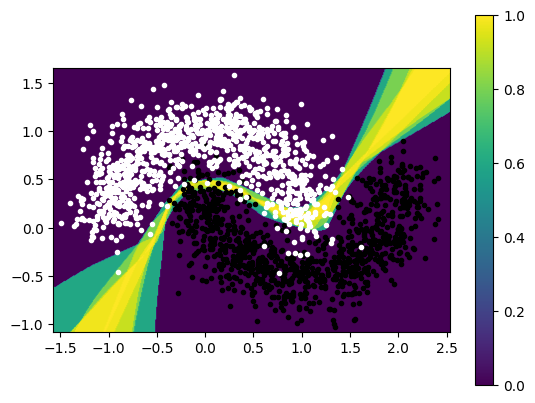

In [12]:
n_syns = [nsyn//100, nsyn//10, nsyn]
if X_gt.targettype == 'classification':
    for n_syn in n_syns:
        X_syns_red = [GenericDataLoader(
            X_syns[i][:n_syn], target_column='target') for i in range(len(X_syns))]
        y_pred_mean, y_pred_std, models = aggregate_imshow(
            X_gt, X_syns_red, prediction_task, models=None, task_type='mlp', load=load, save=save, filename=f'n_syn{n_syn}_gende')


### Single model
Now let's look at the same behaviour by a single data and a downstream DE

Train model 1/10
Train model 2/10
Train model 3/10
Train model 4/10
Train model 5/10
Train model 6/10
Train model 7/10
Train model 8/10
Train model 9/10
Train model 10/10


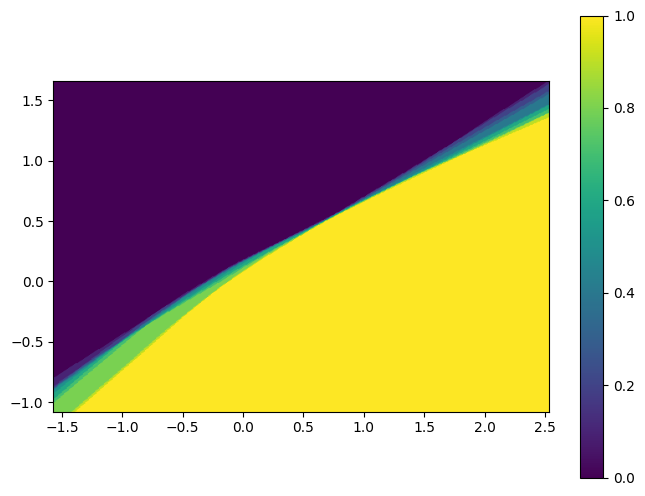

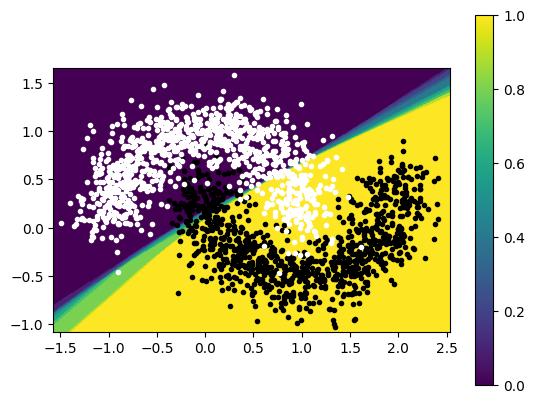

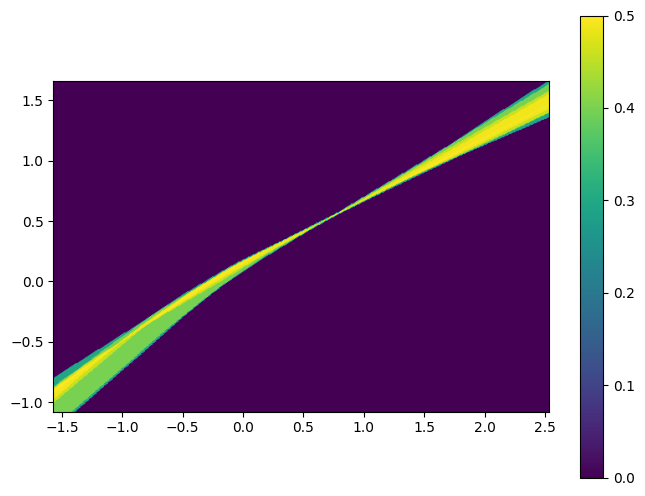

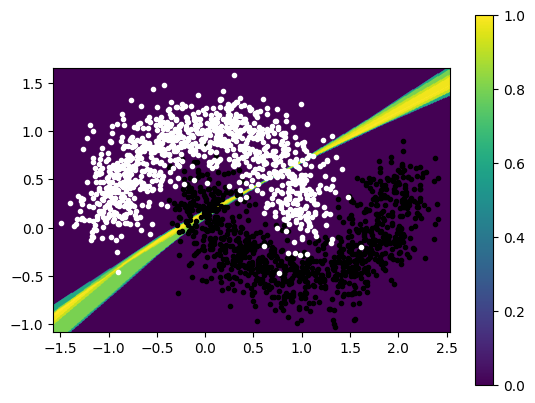

Train model 1/10
Train model 2/10
Train model 3/10
Train model 4/10
Train model 5/10
Train model 6/10
Train model 7/10
Train model 8/10
Train model 9/10
Train model 10/10


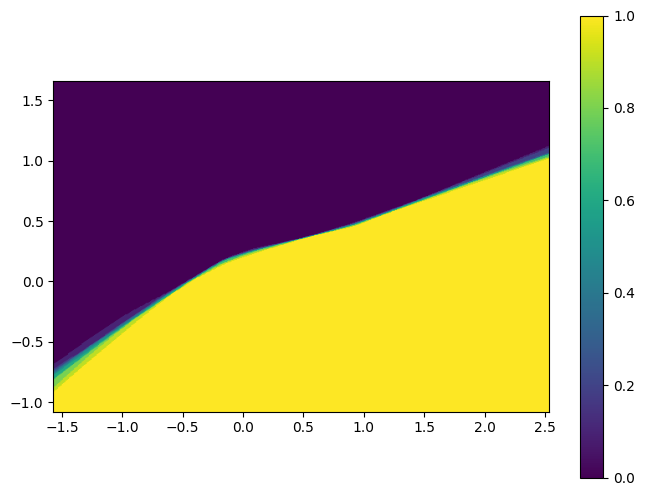

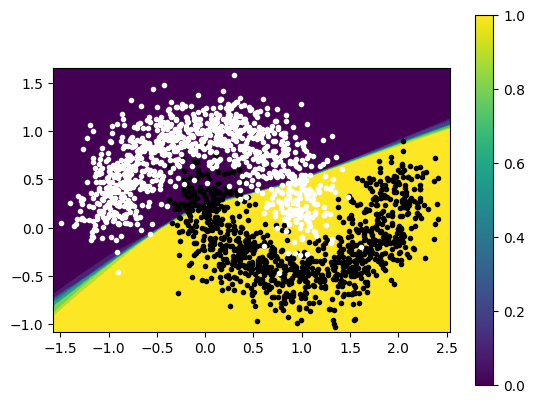

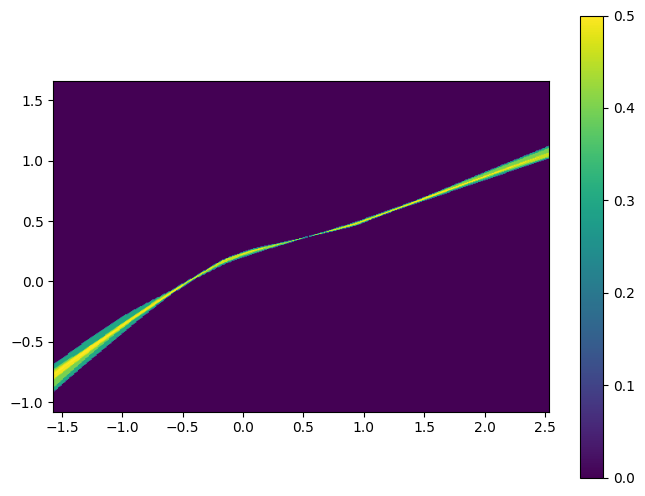

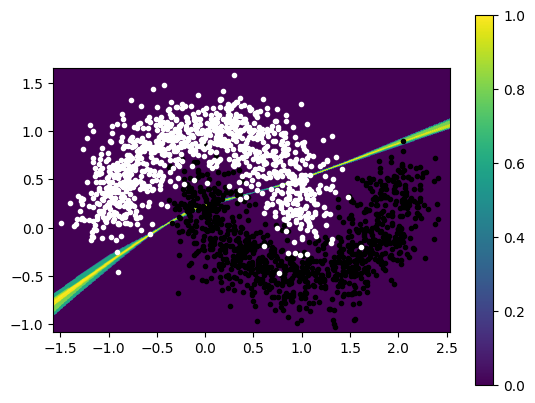

Train model 1/10
Train model 2/10
Train model 3/10
Train model 4/10
Train model 5/10
Train model 6/10
Train model 7/10
Train model 8/10
Train model 9/10
Train model 10/10


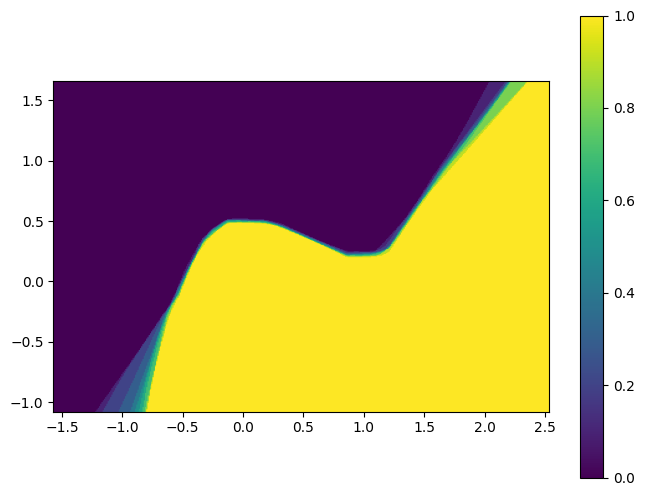

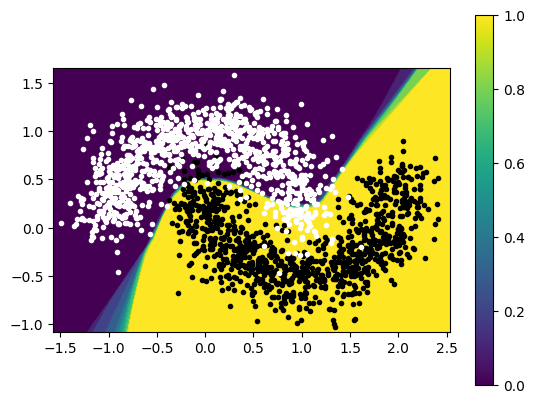

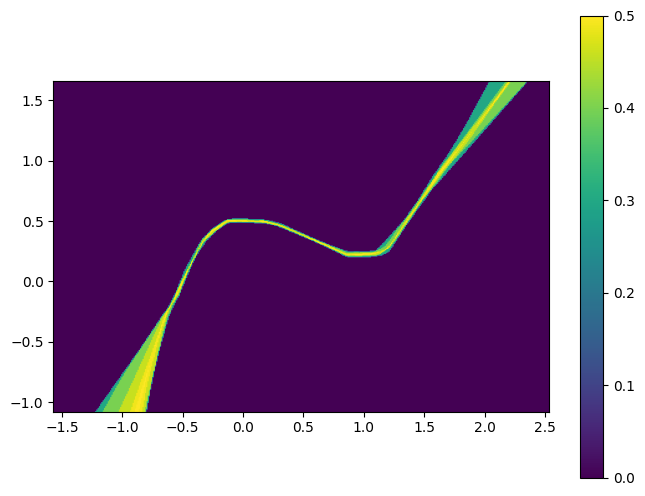

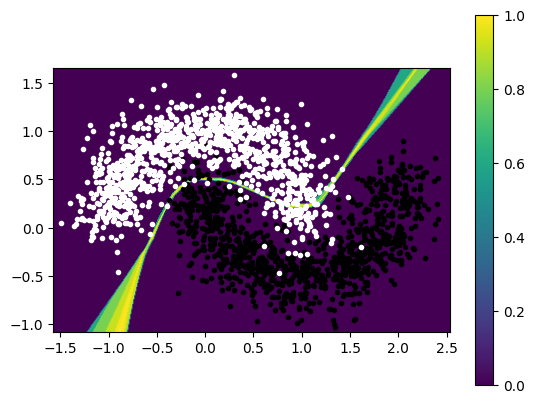

In [13]:
if X_gt.targettype == 'classification':
    for n_syn in n_syns:
        X_syn_0 = [GenericDataLoader(X_syns[1][:n_syn], target_column='target')
                   for i in range(len(X_syns))]
        y_pred_mean, y_pred_std, models = aggregate_imshow(
            X_gt, X_syn_0, prediction_task, models=None, task_type='mlp', load=False, save=save, filename=f'n_syn{n_syn}_single')


### Aggregated data
And what happens when using all data for the downstream DE?

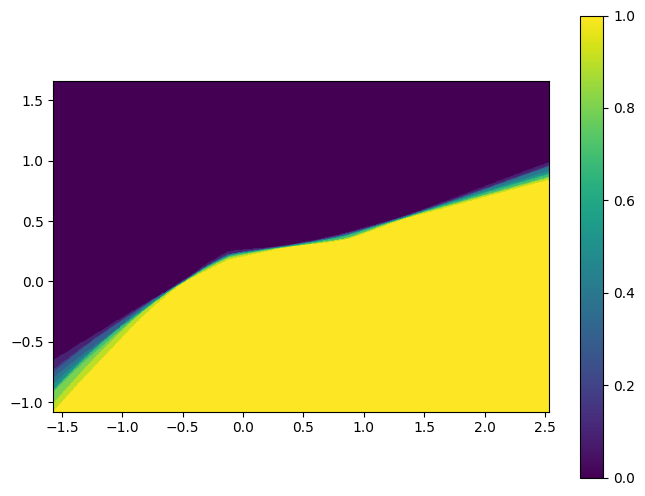

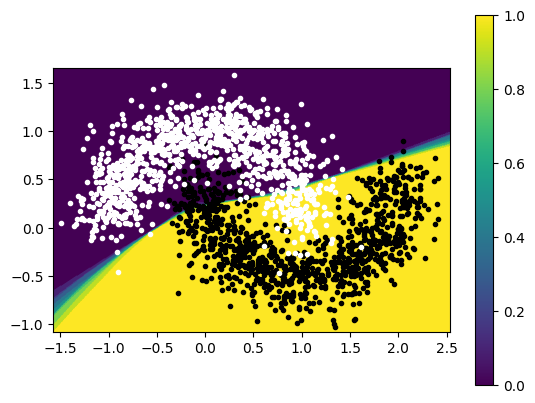

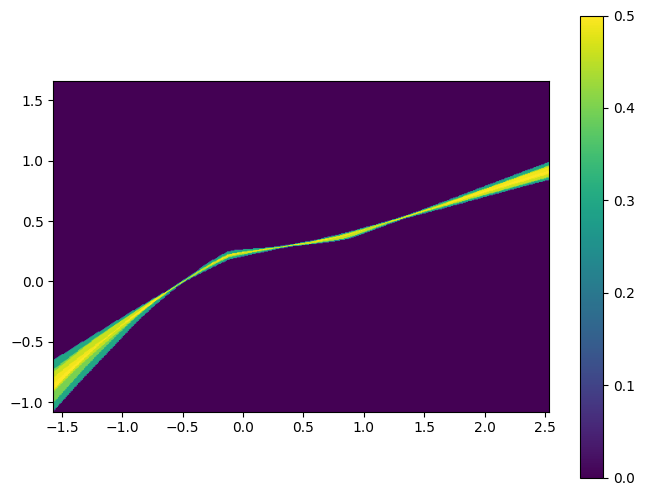

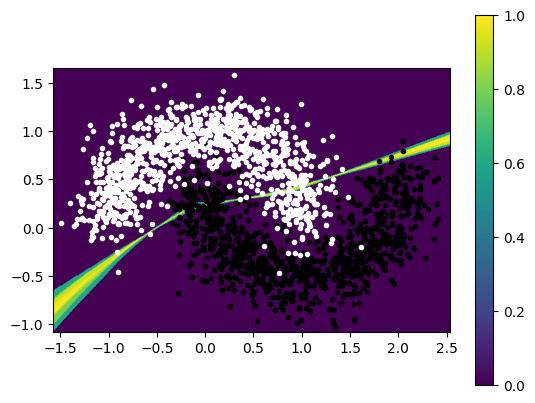

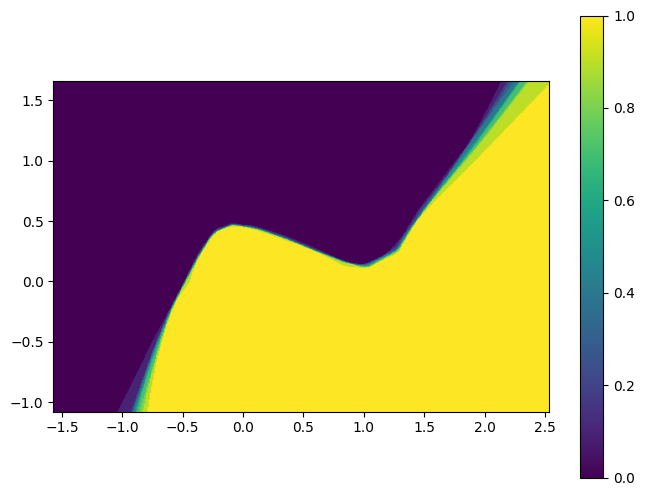

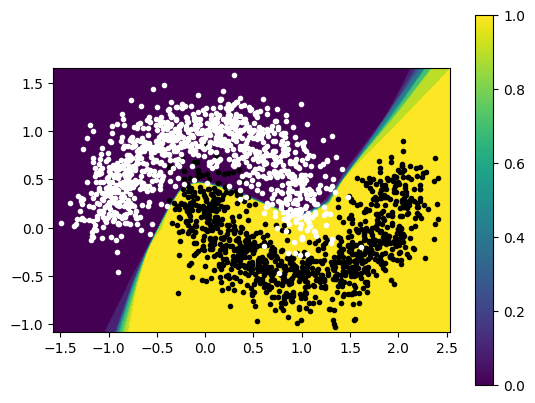

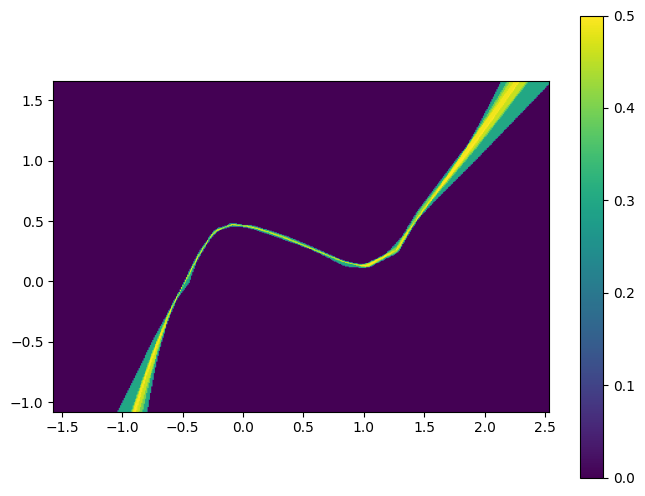

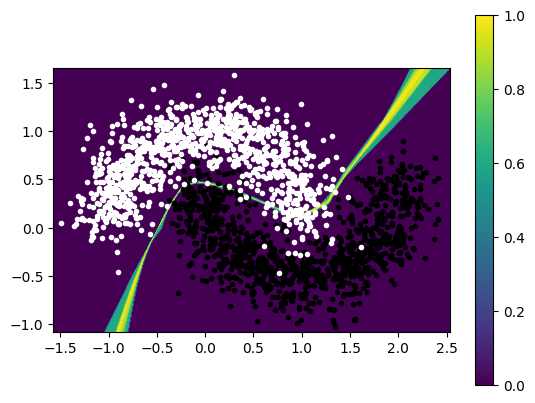

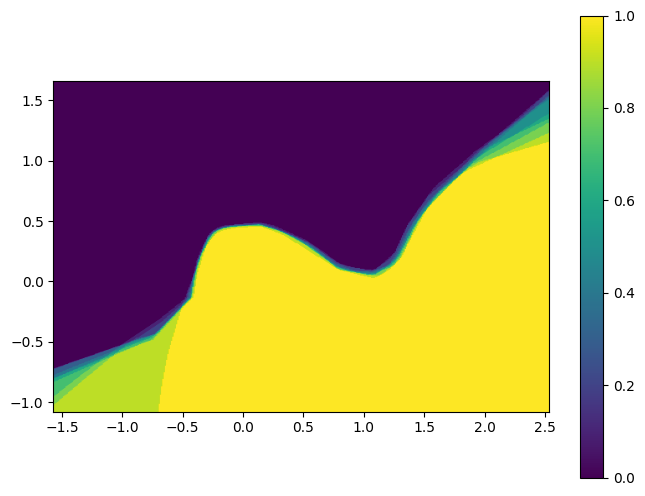

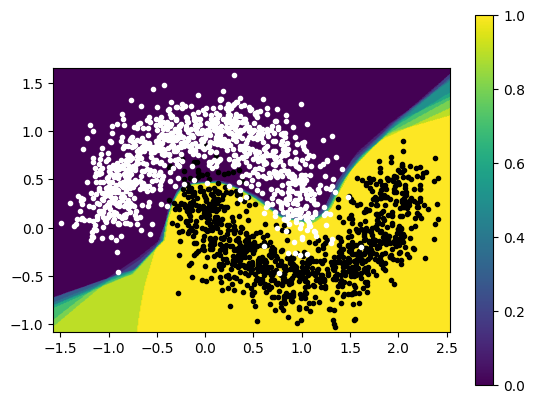

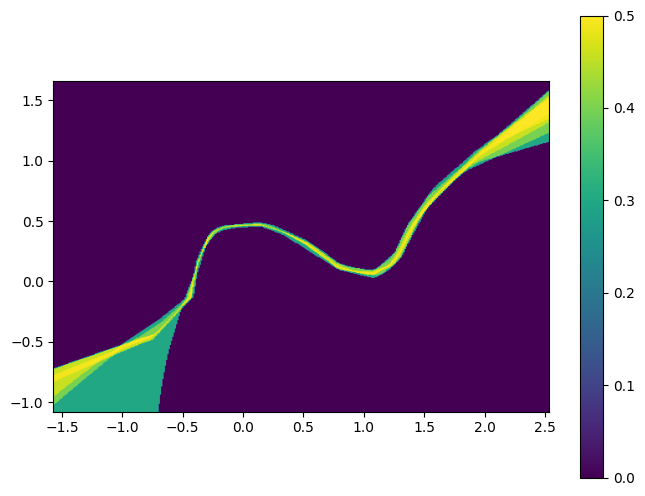

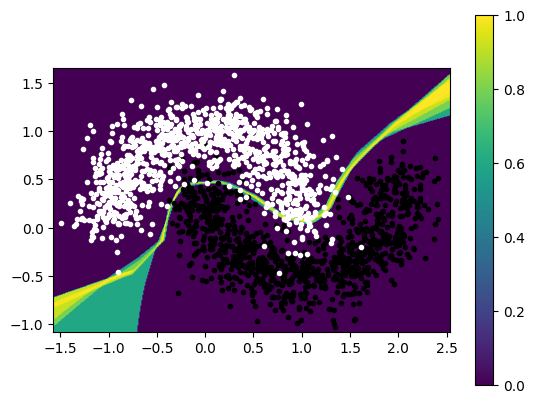

In [14]:
if X_gt.targettype == 'classification':
    for n_syn in n_syns:
        X_syn_cat = cat_dl(X_syns, n_limit=n_syn)
        X_syn_cat = [X_syn_cat for _ in range(len(X_syns))]
        #X_syn_cat = [X_syn_cat.sample(len(X_syns[0])) for _ in range(len(X_syns))]

        y_pred_mean, y_pred_std, models = aggregate_imshow(
            X_gt, X_syn_cat, prediction_task, models=None, task_type='mlp', load=load, save=save, filename=f'n_syn{n_syn}_aggregate')


# Model Evaluation

We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow.
0. Train and generate synthetic datasets $S_i$.
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic dataset's test set $S_{i,test}$, giving $\hat{M}^S_i$ [Single performance]
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
5. Evaluate on the other synthetic datasets $\cup_{j\neq i} S_{j}$, giving $\hat{M}^G_i$ [Generative performance]
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 
7. Repeat 1-6 for different model classes $f$

N.B. the idea of the above, is that the trained model $f_i$ is the same for each evaluation type. In the model selection section, we will compare the performance of different model classes, where we will train a new model for each evaluation type (hence the aim is to evaluate which class is best, while the model itself may vary).

In [15]:
def aggregate_approaches(model_type, relative = False):
    models = None
    means = []
    stds = []
    approaches = ['oracle', 'single', 'us']
    for i, approach in enumerate(approaches):
        mean, std, models = aggregate_predictive(
            X_gt, X_syns, models=models, task_type=model_type, load=load, save=save, approach=approach, relative = relative, verbose = False)
        means.append(mean)
        stds.append(std)

    
    means = pd.concat(means,axis=0)
    stds = pd.concat(stds,axis=0)
    means *= 100
    stds *= 100
    means = means.round(2)
    stds = stds.round(2)
    res = means.astype(str) + ' ± ' + stds.astype(str)
    res.index = approaches
    res.index.Name = 'Approach'
    return res, means, stds

if X_gt.targettype is not None:
    print('Aggregate approaches:')
    print(aggregate_approaches('mlp')[0])

Aggregate approaches:
             roc_auc      accuracy            f1     precision        recall  \
oracle  93.51 ± 0.13  93.51 ± 0.13  93.68 ± 0.12   91.19 ± 0.2   96.32 ± 0.2   
single  91.23 ± 2.55  91.21 ± 2.63  91.31 ± 2.69  89.47 ± 4.02  93.31 ± 2.44   
us      90.77 ± 0.31  90.76 ± 0.32  90.88 ± 0.33   89.2 ± 0.51  92.63 ± 0.32   

                   nll        brier  
oracle   224.29 ± 4.46  6.49 ± 0.13  
single   303.6 ± 90.95  8.79 ± 2.63  
us      319.27 ± 10.93  9.24 ± 0.32  


# Model Selection
Essentially repeat the above for different models

In [16]:

if X_gt.targettype is not None:
    model_types = ['lr', 'mlp', 'rf', 'knn', 'svm', 'xgboost']
    metric = 'accuracy'
    results = []
    means = []
    relative = 'l1'
    for i, model_type in enumerate(model_types):
        res, mean, _ = aggregate_approaches(model_type, relative=relative)
        results.append(res[metric])
        means.append(mean[metric])
    
    means = pd.concat(means,axis=1)
    means.index = ['oracle', 'single', 'us']
    means.columns = model_types
    results = pd.concat(results, axis=1)
    results.columns = model_types


In [17]:
# sort based on oracle
sorting = [model_types[i] for i in means.loc['oracle'].argsort()]
means = means.loc[:,sorting]
results = results.loc[:,sorting]
results

,lr,rf,knn,xgboost,mlp,svm
oracle,86.45 ± 0.0,92.8 ± 0.09,93.22 ± 0.0,93.46 ± 0.0,93.51 ± 0.13,93.79 ± 0.0
single,2.94 ± 1.36,3.27 ± 2.74,2.84 ± 2.45,2.91 ± 2.56,2.72 ± 2.21,2.68 ± 2.35
us,1.13 ± 0.32,1.84 ± 0.49,3.01 ± 0.3,2.95 ± 0.34,2.75 ± 0.28,2.84 ± 0.31


In [18]:
means_sorted = means.loc[:,sorting]

for approach in ['oracle', 'single', 'us']:
    sorting_k = means_sorted.loc[approach].argsort()
    sorting_k = sorting_k.argsort()
    means_sorted.loc[approach+' rank'] = sorting_k.astype(int)+1

means_sorted.iloc[3:].astype(int)
print(means_sorted)

                lr     rf    knn  xgboost    mlp    svm
oracle       86.45  92.80  93.22    93.46  93.51  93.79
single        2.94   3.27   2.84     2.91   2.72   2.68
us            1.13   1.84   3.01     2.95   2.75   2.84
single rank   5.00   6.00   3.00     4.00   2.00   1.00
us rank       1.00   2.00   6.00     5.00   3.00   4.00
oracle rank   1.00   2.00   3.00     4.00   5.00   6.00


In [19]:
results

,lr,rf,knn,xgboost,mlp,svm
oracle,86.45 ± 0.0,92.8 ± 0.09,93.22 ± 0.0,93.46 ± 0.0,93.51 ± 0.13,93.79 ± 0.0
single,2.94 ± 1.36,3.27 ± 2.74,2.84 ± 2.45,2.91 ± 2.56,2.72 ± 2.21,2.68 ± 2.35
us,1.13 ± 0.32,1.84 ± 0.49,3.01 ± 0.3,2.95 ± 0.34,2.75 ± 0.28,2.84 ± 0.31


# Cross validation

We compare the single baseline model vs the generative uncertainty model. Single workflow
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}$
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.

Versus our baseline
1. Take each synthetic dataset $S_i$ and split it up in train and test
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.


Cross-validation approach to test which type of model would perform best on real data. We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow Cross-validation.
0. Train and generate synthetic datasets $S_i$.
1. Use CV to train and evaluate models $f_i$ on each $S_i$. Repeat for all $S_i$. [Single performance]
2. Use CV \textit{over datasets $S_i$} (i.e. train on all but one $S_i$, evaluate on remaining and repeat) to train and evaluate models $f_i$.
3. For both cases, evaluate the model also on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
4. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 

# Model parameter estimation
Using a linear model

# Calibration

In [ ]:
from sklearn.calibration import calibration_curve



prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=3)
